In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn")

# Fetch PES Points 

In [2]:
path = "../TaskC/pes.tab"

r = []
E_HF = []
E_CCSDT = []

with open(path, "r") as f:
    for line in f:
        try:
            splits = list(map(float, line.split()))

            r.append(splits[0])
            E_HF.append(splits[1])
            E_CCSDT.append(splits[2])
        except:
            pass
        
#r = np.asarray(r)
E_HF = np.asarray(E_HF)
E_CCSDT = np.asarray(E_CCSDT)

# Display PES 

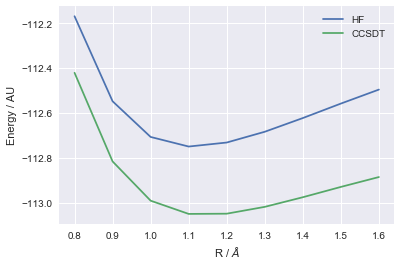

In [3]:
plt.plot(r, E_HF, label="HF")
plt.plot(r, E_CCSDT, label="CCSDT")

plt.xlabel("R / $\AA$")
plt.ylabel("Energy / AU")

plt.legend()

# Make Hamiltonian 

In [4]:
N = len(r)

In [10]:
from scipy.constants import physical_constants

# TODO units should be in AU!!
u = physical_constants["atomic mass constant"][0]

m_C = 12 * u
m_O = 16 * u

## Kinetic Term

In [6]:
from scipy.constants import hbar

mu = m_C * m_O / (m_C + m_O)

P = hbar**2 / (2 * mu) * (
    np.diag(2 * np.ones(N)) + \
    np.diag(-1 * np.ones(N-1), -1) + \
    np.diag(-1 * np.ones(N-1), +1)
)
    

## Potential Term 

In [8]:
U_HF = np.diag(E_HF)
U_CCSDT = np.diag(E_CCSDT)

## H = P + U 

In [9]:
H_HF = P + U_HF
H_CCSDT = P + U_CCSDT

#  Solve Finite Differences Equations


Eigenvalueproblem: $\hat{H} |\psi\rangle = E |\psi\rangle$

Finite differences: $\psi = \{\psi_1, \psi_2, \ldots, \psi_n\}$

## HF 

In [13]:
E, psi = np.linalg.eigh(H_HF)

In [14]:
print(E)

[-112.7498623 -112.7319612 -112.7071334 -112.6839472 -112.6228493
 -112.558298  -112.5480291 -112.4958807 -112.1689211]


## CCSD(T) 

In [15]:
E, psi = np.linalg.eigh(H_CCSDT)

In [16]:
print(E)

[-113.050259  -113.0492333 -113.0187939 -112.9912775 -112.9758902
 -112.9298781 -112.8858382 -112.8162797 -112.4210545]
